<a href="https://colab.research.google.com/github/phyml4e/PINNs/blob/main/COMM_PINN/COMM_PINN_CZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code include implementation of COMM-PINN method for cohesive zome model or local damage model with nonlinear softening law.

---



In [ ]:
pip install sciann -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 KB 41.0 MB/s eta 0:00:00


In [ ]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import sciann as sn
from sciann import Variable, Functional, SciModel
from sciann.constraints import Data
from sciann.utils.math import diff
from numpy import gradient

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.12.0 
Python Version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0] 



## **Material model and data/collocation point generation**

In [ ]:
# Material model based on return mapping alg.
def TSL(g,d_i,xid_i,prop):

  k0 = prop[0]             # Initial stiffness
  h1 = prop[1]             # Interface damage hardening parameter 1
  h2 = prop[2]             # Interface damage hardening parameter 2
  y0 = prop[3]             # damage onset
  
  YT = (1 - d_i)*k0*(g**2)    # trial damage release rate (damage driving force)

  phi = YT - (y0 + h1*(1 - math.exp(-h2*xid_i)))    # Damage criteria

  if phi < 0:              # elastic step

    d = d_i
    xid = xid_i
    tngMM = ((1-d)**2)*k0
  
  else:                    # damage step      
    
    d = d_i
    xid = xid_i
    Y = (1 - d)*k0*(g**2)

    rd = np.zeros([2, 1])
    rd[0,0] = d - d_i - (xid - xid_i)
    #rd[1,0] = Y - (y0 + h1*h2*xid)
    rd[1,0] = Y - (y0 + h1*(1 - math.exp(-h2*xid)))

    while np.linalg.norm(rd) > 10**(-10):

      Kd = np.zeros([2,2])
      Kd[0,0] = 1
      Kd[0,1] = -1
      Kd[1,0] = -k0*(g**2)
      #Kd[1,1] = -h1*h2
      Kd[1,1] = -h1*h2*math.exp(-h2*xid)            

      Dsol = np.linalg.lstsq(-Kd, rd)[0]
      d = d + Dsol[0,0]                             # evol "D"
      xid = xid + Dsol[1,0]                         # evol 
      Y = (1 - d)*k0*(g**2)                         # stress

      rd[0,0] = d - d_i - (xid - xid_i)                   # final evol eq
      #rd[1,0] = Y - (y0 + h1*h2*xid)
      rd[1,0] = Y - (y0 + h1*(1 - math.exp(-h2*xid)))     # final yeild fn

    tngMM = k0*(1 - k0/(k0 + h1*h2*np.exp(-h2*xid) ))
      
    if d < d_i:
      d = d_i
      xid = xid_i

  tra = ((1-d)**2)*(k0*g)
  ene = (((1-d)**2)*(0.5*k0)*(g**2)) + (h1*(xid + (math.exp(-h2*xid)-1)/h2))
  
  return tra,d,xid,ene,tngMM

In [ ]:
# Generation of collocation points

# Material Parameters
k0   = 5.0         # Initial stiffness
h1   = 2.0         # Interface damage hardening parameter 1
h2   = 1.0         # Interface damage hardening parameter 2
y0   = 0.1         # Damage onset
prop = [k0, h1, h2, y0]
       
step = 0.005    
endg = 1
n    = 0

pg = np.array(np.arange(0.0, endg+step, step))
pd = np.array(np.arange(0.0, endg+step, step))
px = np.array(np.arange(0.0, endg+step, step))

print(len(pg))
#print(pg)

row = len(pg)*len(pd)*len(px)
INe = np.zeros((row,3))

for i in range(len(pg)):                           
    for j in range(len(px)):
        for k in range(len(pd)):
            INe[n,0] = pg[i]
            INe[n,1] = pd[j]
            if px[k] == pd[j]: 
               INe[n,2] = px[k]
               n += 1
            
IN  = np.zeros((n,3))
n = 0     
for i in range(len(pg)):                           
    for j in range(len(px)):
        for k in range(len(pd)):
            IN[n,0] = pg[i]
            IN[n,1] = pd[j]
            if px[k] == pd[j]: 
               IN[n,2] = px[k]
               n += 1

print(len(IN[:,0]))
print(n)

201
8120601
40401
40401


# **Training**

In [ ]:
#Designinh the network
dtype     = 'float32' 
n_of_n    = 5*[100]        # Number of neurons (layers*[neurons]) 
act       = 'Relu'         # Activation function  # "tanh", "softplus", "Relu", "sigmoid", "softmax" 
Epochs    = 2000           # Number of epochs  
batch     = 100            # Batch size 
LR        = 0.0001         # Learning rate   
Optimizer ='adam'          # such as 'scipy-l-BFGS-B' , 'SGD'

x1 = sn.Variable('x1', dtype=dtype)
x2 = sn.Variable('x2', dtype=dtype)
x3 = sn.Variable('x3', dtype=dtype)

y2 = sn.Functional('y2',[x1, x2, x3], n_of_n, act)
y3 = sn.Functional('y3',[x1, x2, x3], n_of_n, act)

dy2dx1 = diff(y2,x1) 

#Splitting the data into inputs and outputs
x1_1 = IN[:,0] #np.array(df_1.iloc[:,0])       # Gap    
x2_1 = IN[:,1] #np.array(df_1.iloc[:,1])       # Damage variable @ n
x3_1 = IN[:,2] #np.array(df_1.iloc[:,2])       # Damage hardening variable @ n


In [ ]:
#Defining the physical constraints
kpe = 1.0
kpd = 1.0                   #penalty term
kpx = 1.0                   #penalty term
kpy = 1.0                   #penalty term
kpu = 1.0                   #penalty term  

phi    = (1-y2)*k0*(x1**2) - (y0 + h1*(1 - sn.exp(-h2*y3))) # yield function:    Y = (1 - d)*k0*(g**2),    phi_d = Y - (y0 + h1*(1 - math.exp(-h2*xid)))
phi_o  = (1-x2)*k0*(x1**2) - (y0 + h1*(1 - sn.exp(-h2*x3)))

#physical constraints 
const1 = kpu*(y2-x2)*sn.relu(-phi_o)                # unload d
const2 = kpu*(y3-x3)*sn.relu(-phi_o)                # unload xid   
const3 = kpe*( y2-x2 - (y3-x3) )*sn.relu(phi_o)     # evolution eq.  d - d_i - (xid - xid_i)
const4 = kpy*phi*sn.relu(phi_o)                     # yield function
const5 = kpd*(1.0)*sn.relu(phi)                     # growing d      
const6 = kpx*(1.0)*sn.relu(x3-y3)                   # growing xid   
  

In [ ]:
#Defining the model
model = sn.SciModel([x1, x2, x3],[const1, const2, const3, const4, const5, const6], loss_func="mse", optimizer = Optimizer)

#Defining the inputs and outputs
x_data = [x1_1, x2_1, x3_1]
y_data = ['zeros', 'zeros', 'zeros', 'zeros', 'zeros', 'zeros']


In [ ]:
ADAPTIVE_WEIGHTS = {'method': 'GN', 'freq': 100, 'use_score': True, 'alpha': 1.0}

In [ ]:
#Fitting the model
history1 = model.train(x_data, y_data, learning_rate=LR, epochs=Epochs, batch_size=batch,verbose=-1)#, **{'adaptive_weights': ADAPTIVE_WEIGHTS})


Total samples: 40401 
Batch size: 100 
Total batches: 405 

Epoch 1/2000
Epoch 2/2000
Epoch 3/2000
Epoch 4/2000
Epoch 5/2000
Epoch 6/2000
Epoch 7/2000
Epoch 8/2000
Epoch 9/2000
Epoch 10/2000
Epoch 11/2000
Epoch 12/2000
Epoch 13/2000
Epoch 14/2000
Epoch 15/2000
Epoch 16/2000
Epoch 17/2000
Epoch 18/2000
Epoch 19/2000
Epoch 20/2000
Epoch 21/2000
Epoch 22/2000
Epoch 23/2000
Epoch 24/2000
Epoch 25/2000
Epoch 26/2000
Epoch 27/2000
Epoch 28/2000
Epoch 29/2000
Epoch 30/2000
Epoch 31/2000
Epoch 32/2000
Epoch 33/2000
Epoch 34/2000
Epoch 35/2000
Epoch 36/2000
Epoch 37/2000
Epoch 38/2000
Epoch 39/2000
Epoch 40/2000
Epoch 41/2000
Epoch 42/2000
Epoch 43/2000
Epoch 44/2000
Epoch 45/2000
Epoch 46/2000
Epoch 47/2000
Epoch 48/2000
Epoch 49/2000
Epoch 50/2000
Epoch 51/2000
Epoch 52/2000
Epoch 53/2000
Epoch 54/2000
Epoch 55/2000
Epoch 56/2000
Epoch 57/2000
Epoch 58/2000
Epoch 59/2000
Epoch 60/2000
Epoch 61/2000
Epoch 62/2000
Epoch 63/2000
Epoch 64/2000
Epoch 65/2000
Epoch 66/2000
Epoch 67/2000
Epoch 68/2

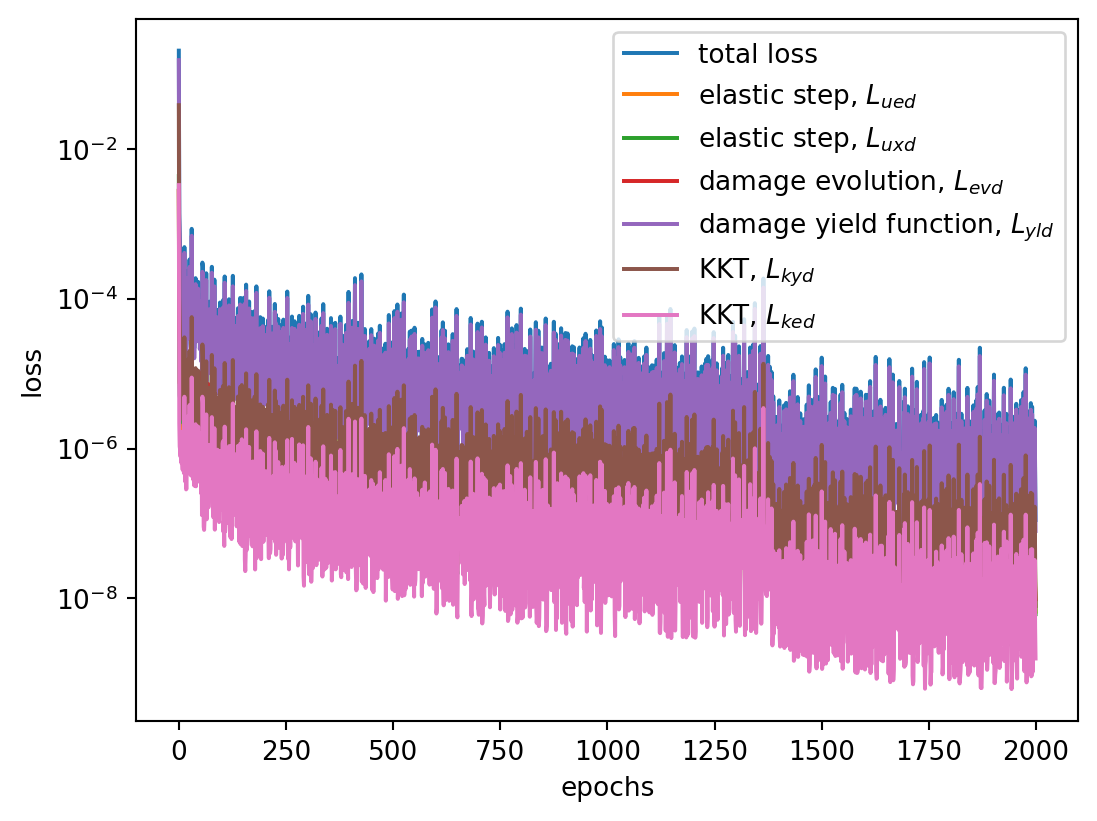

In [ ]:
loss_name = ['total loss','elastic step, $L_{ued}$','elastic step, $L_{uxd}$', 'damage evolution, $L_{evd}$','damage yield function, $L_{yld}$', 'KKT, $L_{kyd}$', 'KKT, $L_{ked}$']

#fig = plt.figure(figsize=(12, 7))
fig = plt.figure(dpi = 190)
itter = 0 
for word, loss in history1.history.items():
        if word.endswith("loss"):
            plt.semilogy(np.array(loss), label=loss_name[itter])
            itter+=1
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.savefig('loss_dmg.pdf')

# **POST PROCESS**

<Figure size 640x480 with 0 Axes>

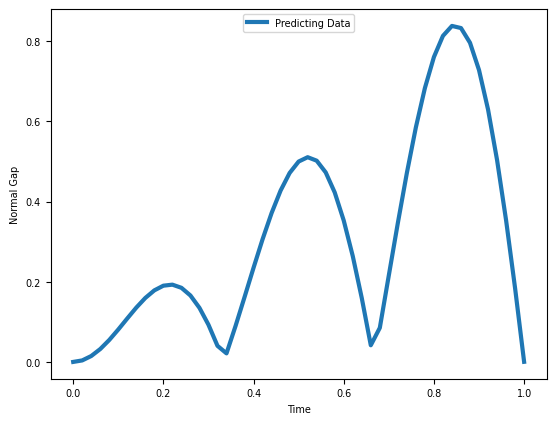

In [ ]:
#Defining a new loading path for prediction
numt  = 51
numtl = numt

t2    = np.linspace(0, 1, numtl)                 # Time
#Ga    = 0.5*abs(t2*np.sin(3.1415*5*t2)) + 0.5*abs(np.sin(3.1415*2*t2))          # Normal gap
Ga    = 1.0*abs(t2*np.sin(3.1415*3*t2))          # Normal gap
#Ga    = 1.0*t2**3
#Ga    = 1.0*t2**1

T = np.linspace(0, 1, numt)
plt.figure()
fig = plt.figure(dpi = 100)

plt.plot(t2, Ga, linewidth=3, label = 'Predicting Data')
plt.legend(loc = "upper center")
plt.xlabel("Time")
plt.ylabel("Normal Gap")
plt.show()


<ipython-input-3-129896e2acf4>:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Dsol = np.linalg.lstsq(-Kd, rd)[0]


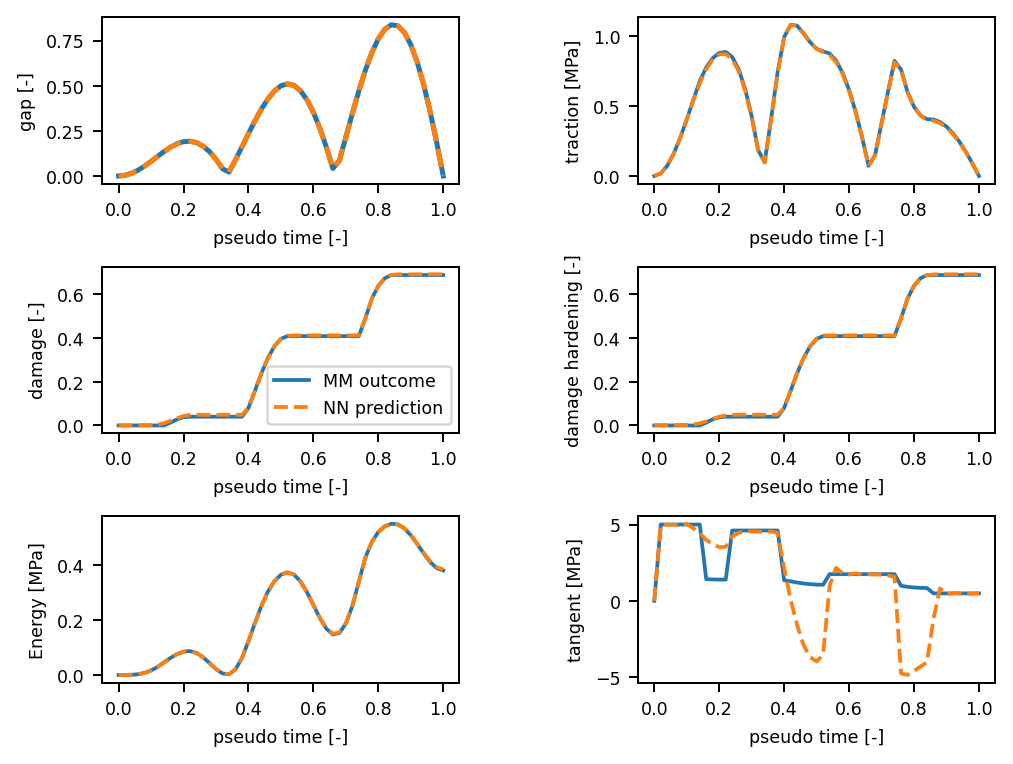

In [ ]:
# loop over loading path material model
#%%timeit

Dmg = np.zeros(len(Ga))            
Xid = np.zeros(len(Ga))          
Tra = np.zeros(len(Ga))
Ene = np.zeros(len(Ga))
tngMM = np.zeros(len(Ga))

for k in range(len(Ga)-1):
    Tra[k+1],Dmg[k+1],Xid[k+1],Ene[k+1],tngMM[k+1] = TSL(Ga[k+1],Dmg[k],Xid[k],prop)


x1_NN = Ga 
x1_NN = x1_NN.reshape(-1,1)
x2_NN = np.zeros_like(x1_NN)
x3_NN = np.zeros_like(x1_NN)
trc_d = np.zeros_like(x1_NN)
trc_N = np.zeros_like(x1_NN)
der = np.zeros_like(x1_NN)
tngNN = np.zeros_like(x1_NN)
eneNN = np.zeros_like(x1_NN)


for k in range(len(Ga)-1):
    #trc_N[k+1] = y1.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    x2_NN[k+1] = y2.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    x3_NN[k+1] = y3.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    trc_d[k+1] = (1 - x2_NN[k+1])**2 * k0 * x1_NN[k+1]
    der[k+1]   = dy2dx1.eval([ x1_NN[k+1], x2_NN[k], x3_NN[k] ])
    tngNN[k+1] = (1.0 - x2_NN[k+1])**2 * k0 - 2*der[k+1]*k0*x1_NN[k+1]
    eneNN[k+1] = 0.5*(x1_NN[k+1]**2)*k0*(1.0 - x2_NN[k+1])**2 + h1*(x3_NN[k+1] + (math.exp(-h2 * x3_NN[k+1])-1)/h2)
    

# plot 
fig = plt.figure(dpi = 180)
plt.rcParams['font.size'] = '7'
fig.subplots_adjust(hspace=0.5, wspace=0.5)
ax = fig.add_subplot(3, 2, 1)

plt.plot(t2, Ga, linewidth=2)
plt.plot(t2, Ga, '--', linewidth=2)
plt.xlabel("pseudo time [-]")
plt.ylabel("gap [-]")

ax = fig.add_subplot(3, 2, 2)
ax.plot(t2, Tra)
ax.plot(t2, trc_d, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("traction [MPa]")

ax = fig.add_subplot(3, 2, 3)
ax.plot(t2, Dmg, label='MM outcome')                       
ax.plot(t2, x2_NN, '--', label = "NN prediction")
plt.xlabel("pseudo time [-]")
plt.ylabel("damage [-]")
plt.legend(loc = "lower right")

ax = fig.add_subplot(3, 2, 4)
ax.plot(t2, Xid)
ax.plot(t2, x3_NN, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("damage hardening [-]")

ax = fig.add_subplot(3, 2, 5)
ax.plot(t2, Ene)
ax.plot(t2, eneNN, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("Energy [MPa]")

ax = fig.add_subplot(3, 2, 6)
ax.plot(t2, tngMM)
ax.plot(t2, tngNN, '--')
plt.xlabel("pseudo time [-]")
plt.ylabel("tangent [MPa]")

plt.savefig('compare_dmg_tot.pdf')